In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ML_for_GreenImaging.PipelineStages import *
from tensorflow.keras import models, optimizers, layers

2023-07-05 10:47:41.851162: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def architecture_1(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu'))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu'))
    network.add(layers.Flatten())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

In [3]:
path = "/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:23:23/imaging exposure time = 30ms"
model = models.load_model(path + "/model1.h5")

In [4]:
loader = Loader.Loader(20, 100, path)
stack, tot_loops, info = loader.run()

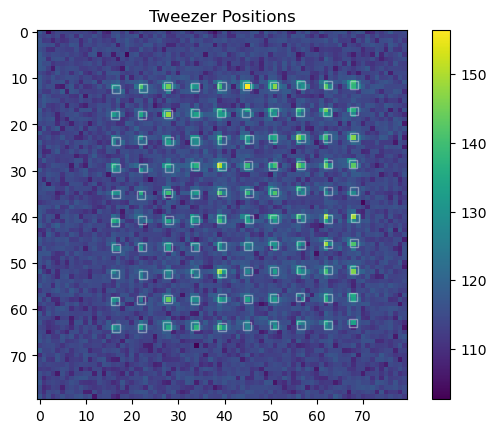

In [5]:
processor = ImageProcessing.ImageProcessor(stack, 100, tot_loops)
crops3x3, crops1x1, positions, info = processor.run()

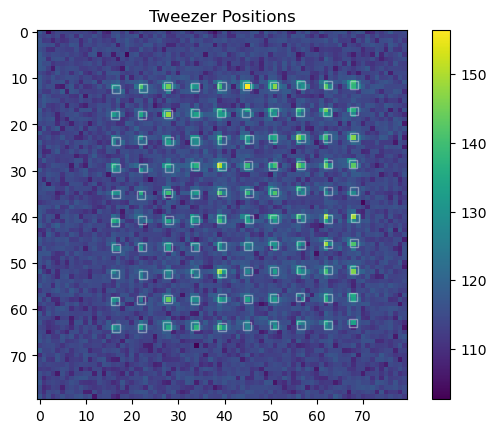

In [6]:
info['Plot']

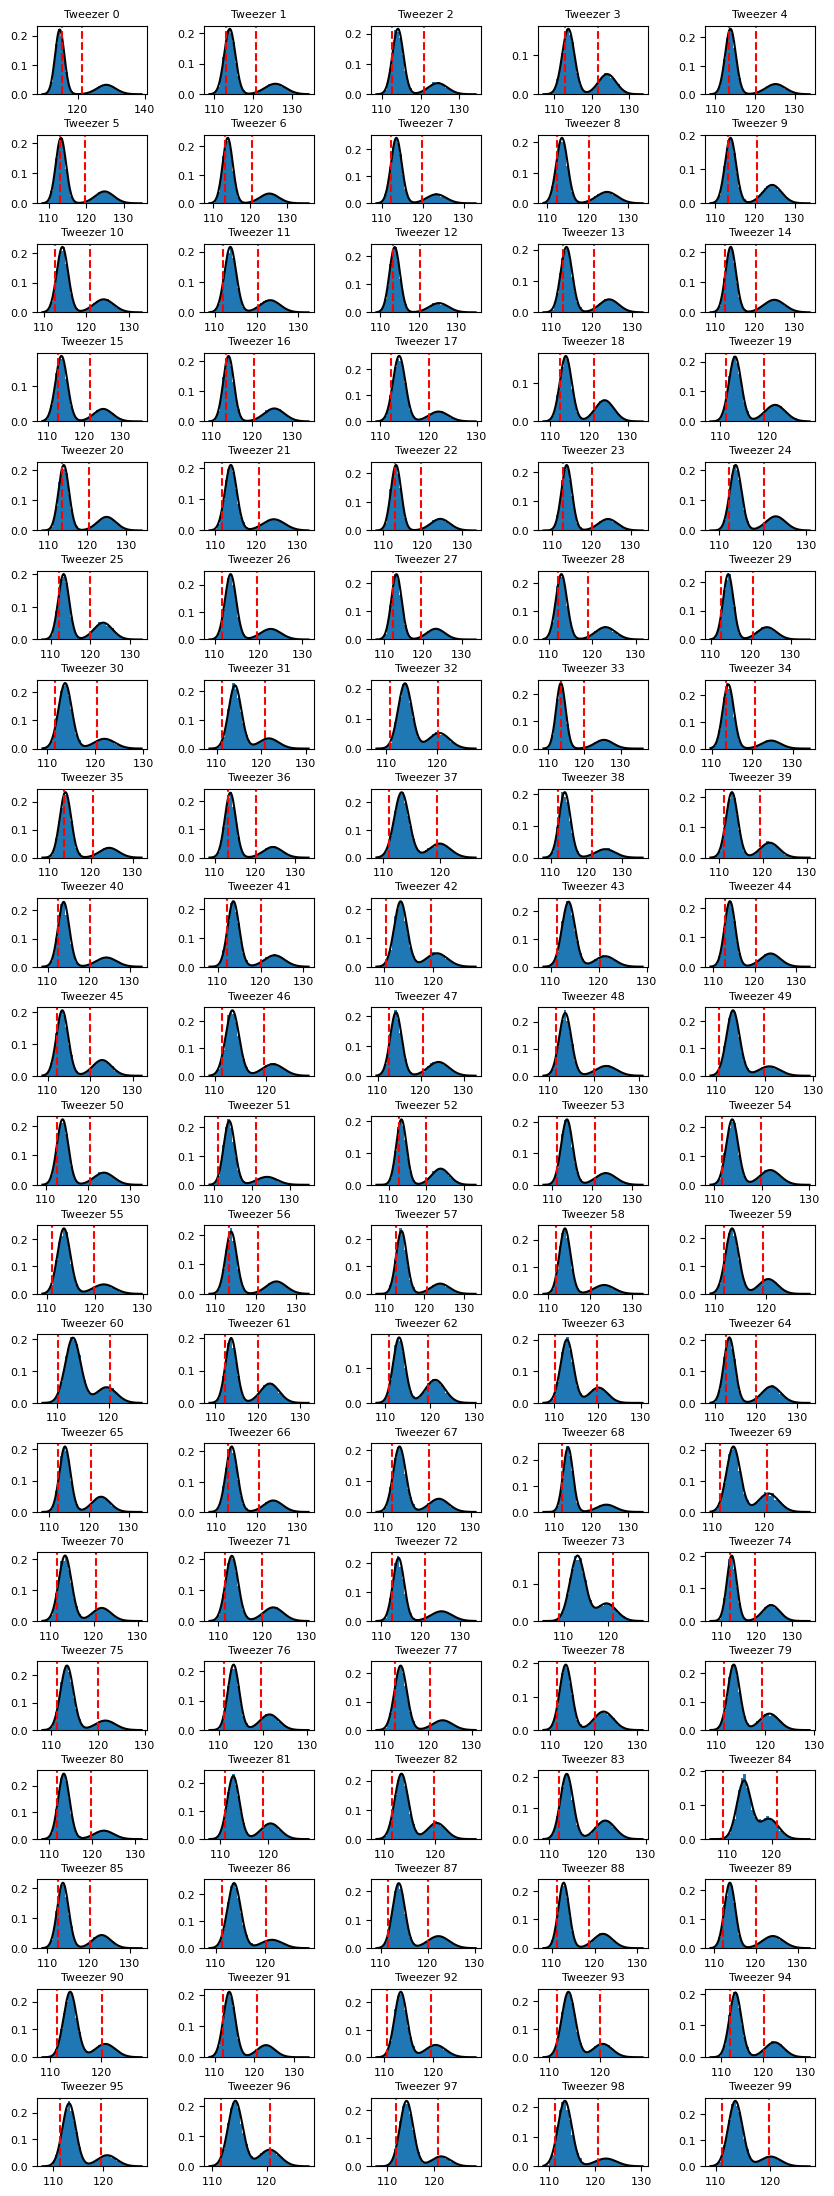

In [7]:
labeler = Labeler.Labeler(crops1x1, 100, tot_loops)
labels, info = labeler.run()

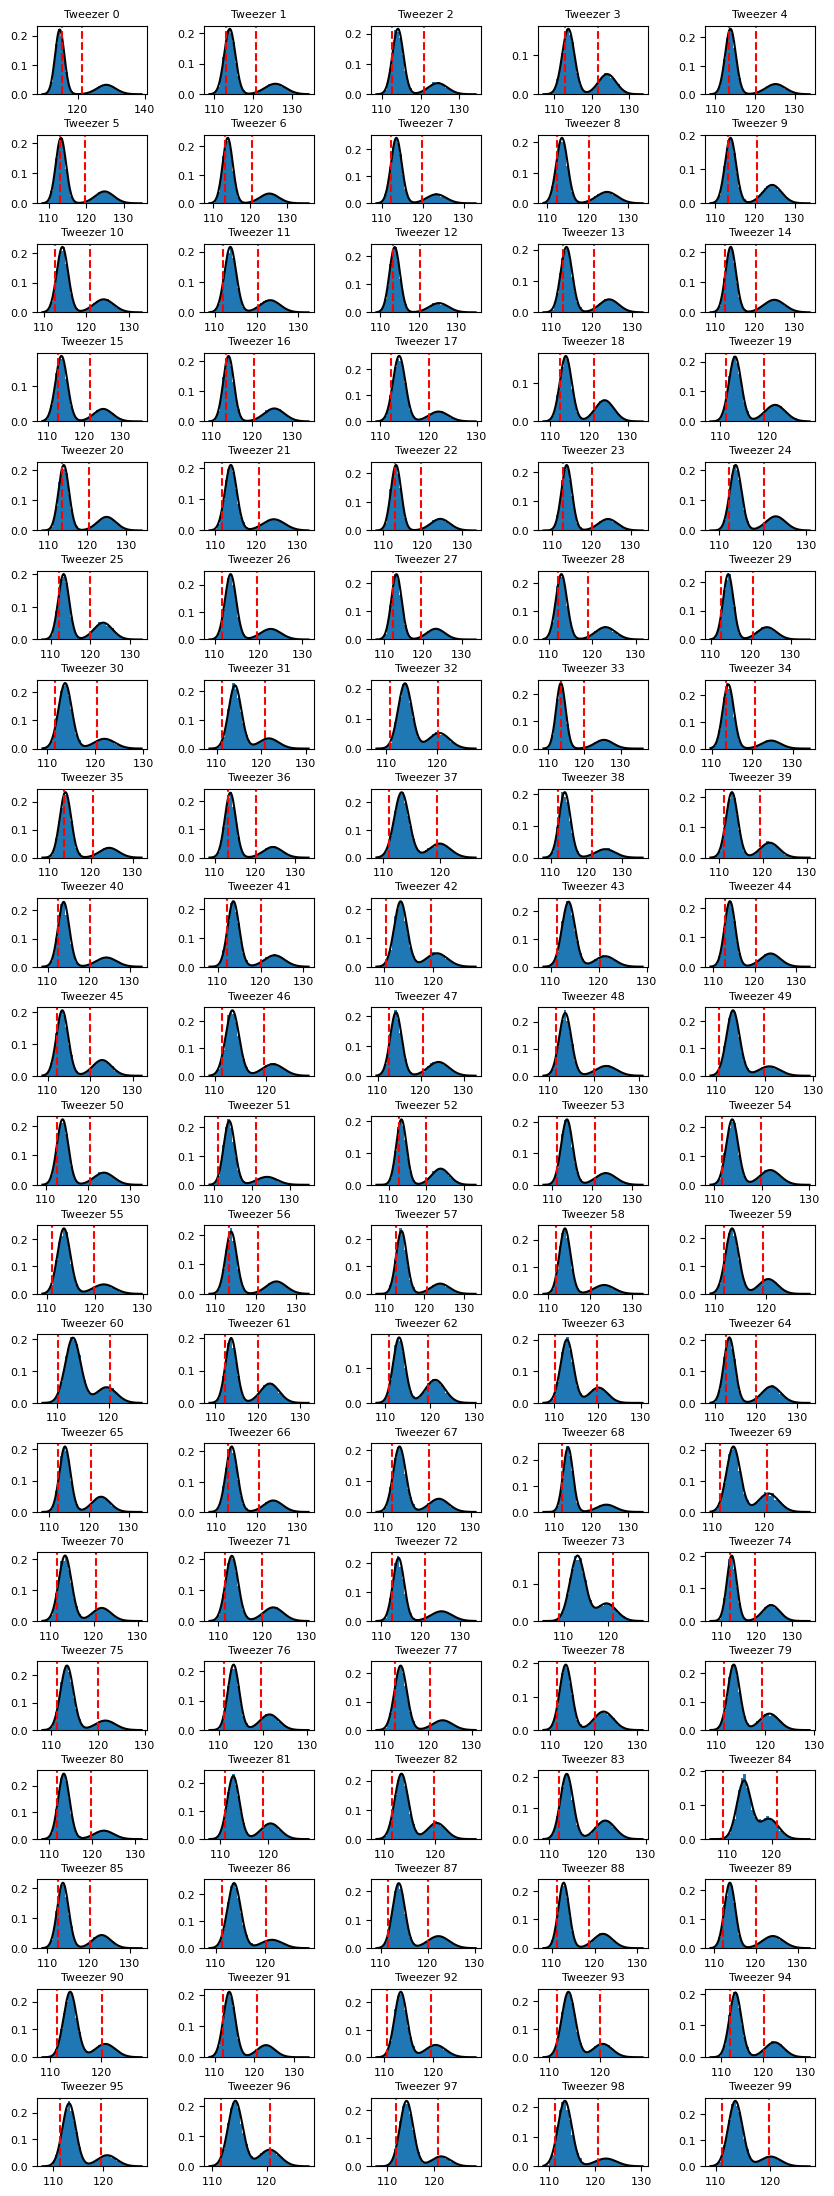

In [14]:
info['Plot'][0]

In [8]:
# Separate labels and crops for each site
crops3x3 = np.reshape(crops3x3, (100, *crops3x3.shape[1:]))
labels = np.transpose(np.array([np.absolute(labels - 1), labels]))
labels = np.reshape(labels, (100, -1, 2))
bad = np.isnan(labels)
keep = ~ bad
labels = [site_labels[site_keep[:, 0]] for site_labels, site_keep in zip(labels, keep)]
crops = [site_crops[site_keep[:, 0]] for site_crops, site_keep in zip(crops3x3, keep)]

In [9]:
# Randomly select 10% of each dataset for evaluation
testing = []
training = []
for tweezer_labels, tweezer_crops in zip(labels, crops):
    testing_indices = np.random.choice(tweezer_labels.shape[0], int(0.1 * tweezer_labels.shape[0]), replace=False)
    testing.append([tweezer_crops[testing_indices], tweezer_labels[testing_indices]])
    training.append([np.delete(tweezer_crops, testing_indices, axis=0), np.delete(tweezer_labels, testing_indices, axis=0)])

In [10]:
# Create 100 NN's 
networks = [architecture_1(crops3x3.shape[2:], [10, 10], [3, 3]) for i in range(100)]
histories = []
test_accuracy = []

In [11]:
for i, tweezer_network in enumerate(networks):
    print(f"Tweezer {i}")
    tweezer_network.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['binary_accuracy'])
    histories.append(tweezer_network.fit(*training[i], epochs=8))
    test_accuracy.append(tweezer_network.evaluate(*testing[i])[1])

Tweezer 0
Epoch 1/8
435/435 [==============================] - 2s 4ms/step - loss: 0.3655 - binary_accuracy: 0.9216
Epoch 2/8
435/435 [==============================] - 2s 4ms/step - loss: 0.0129 - binary_accuracy: 0.9968
Epoch 3/8
435/435 [==============================] - 2s 4ms/step - loss: 0.0059 - binary_accuracy: 0.9989
Epoch 4/8
435/435 [==============================] - 2s 4ms/step - loss: 0.0045 - binary_accuracy: 0.9993
Epoch 5/8
435/435 [==============================] - 2s 5ms/step - loss: 0.0034 - binary_accuracy: 0.9994
Epoch 6/8
349/435 [=======================>......] - ETA: 0s - loss: 0.0037 - binary_accuracy: 0.9993

KeyboardInterrupt: 

In [ ]:
p_db = []
p_bd = []
for i, (network, crops) in enumerate(zip(networks, crops3x3)):
    print(f"Tweezer Number {i}")
    occ = np.argmax(network.predict(crops), axis=1)
    occ = np.reshape(occ, (tot_loops, -1))
    diff = np.diff(occ, axis=1)
    n_dark_to_bright = np.sum(diff == -1)
    n_dark = np.sum(occ[:,:-1] == 0)
    n_bright_to_dark = np.sum(diff == 1)
    n_bright = np.sum(occ[:,:-1] == 1)
    p_db.append(n_dark_to_bright / n_dark)
    p_bd.append(n_bright_to_dark / n_bright)

Tweezer Number 0
994/994 [==============================] - 3s 3ms/step
Tweezer Number 1
994/994 [==============================] - 2s 2ms/step
Tweezer Number 2
994/994 [==============================] - 1s 1ms/step
Tweezer Number 3
994/994 [==============================] - 1s 1ms/step
Tweezer Number 4
994/994 [==============================] - 1s 1ms/step
Tweezer Number 5
994/994 [==============================] - 1s 1ms/step
Tweezer Number 6
994/994 [==============================] - 1s 1ms/step
Tweezer Number 7
994/994 [==============================] - 1s 1ms/step
Tweezer Number 8
994/994 [==============================] - 1s 1ms/step
Tweezer Number 9
994/994 [==============================] - 1s 1ms/step
Tweezer Number 10
994/994 [==============================] - 1s 1ms/step
Tweezer Number 11
994/994 [==============================] - 1s 1ms/step
Tweezer Number 12
994/994 [==============================] - 1s 1ms/step
Tweezer Number 13
994/994 [==============================] - 

/var/folders/2f/l2325khj6r1d2csvqvdf7v280000gn/T/ipykernel_95343/2261506367.py:12: RuntimeWarning: invalid value encountered in scalar divide
  p_db.append(n_dark_to_bright / n_dark)


994/994 [==============================] - 1s 1ms/step
Tweezer Number 35
994/994 [==============================] - 1s 1ms/step
Tweezer Number 36
994/994 [==============================] - 1s 1ms/step
Tweezer Number 37
994/994 [==============================] - 1s 1ms/step
Tweezer Number 38
994/994 [==============================] - 1s 1ms/step
Tweezer Number 39
994/994 [==============================] - 1s 1ms/step
Tweezer Number 40
994/994 [==============================] - 1s 1ms/step
Tweezer Number 41
994/994 [==============================] - 1s 1ms/step
Tweezer Number 42
994/994 [==============================] - 1s 1ms/step
Tweezer Number 43
994/994 [==============================] - 1s 1ms/step
Tweezer Number 44
994/994 [==============================] - 1s 1ms/step
Tweezer Number 45
994/994 [==============================] - 1s 1ms/step
Tweezer Number 46
994/994 [==============================] - 1s 1ms/step
Tweezer Number 47
994/994 [==============================] - 1s 1ms/s

In [ ]:
p_db = np.array(p_db)
p_bd = np.array(p_bd)

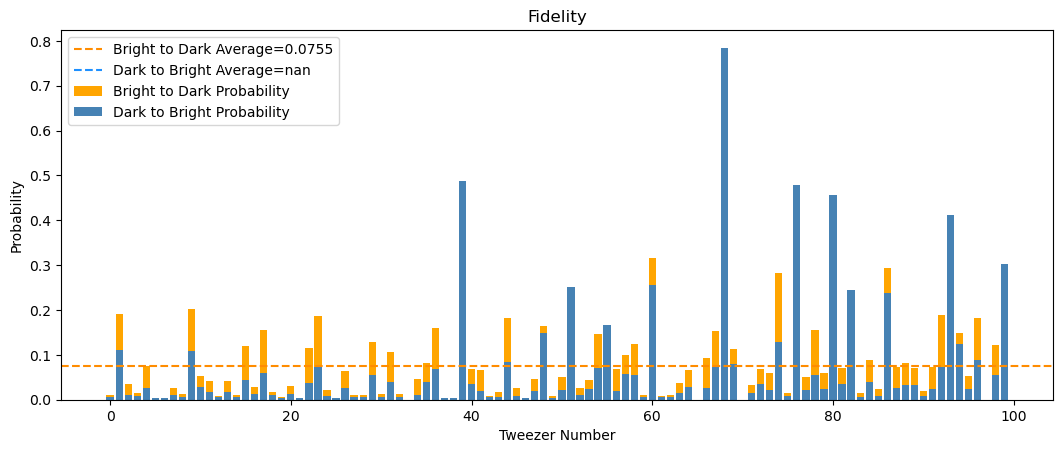

In [ ]:
plt.figure(figsize=(12.8, 4.8))
plt.bar(np.arange(100), p_bd, label=f'Bright to Dark Probability', color='orange')
plt.bar(np.arange(100), p_db, label=f'Dark to Bright Probability', color='steelblue')
plt.axhline(p_bd.mean(), label=f"Bright to Dark Average={np.mean(p_bd):.3}", color='darkorange', linestyle='--')
plt.axhline(p_db.mean(), label=f"Dark to Bright Average={np.mean(p_db):.3}", color='dodgerblue', linestyle='--')
plt.xlabel('Tweezer Number')
plt.ylabel('Probability')
plt.legend(loc='upper left')
plt.title('Fidelity')
plt.show()

In [ ]:
print(np.sum(labels[92], axis=0))

[4944. 3572.]


In [ ]:
networks[0].summary()

Model: "sequential_500"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1000 (Conv2D)        (None, 14, 14, 10)        100       
                                                                 
 conv2d_1001 (Conv2D)        (None, 12, 12, 10)        910       
                                                                 
 flatten_500 (Flatten)       (None, 1440)              0         
                                                                 
 dense_500 (Dense)           (None, 2)                 2882      
                                                                 
Total params: 3,892
Trainable params: 3,892
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i, network in enumerate(networks):
    network.save(f"tiny_networks/tiny_network_{i}.h5")

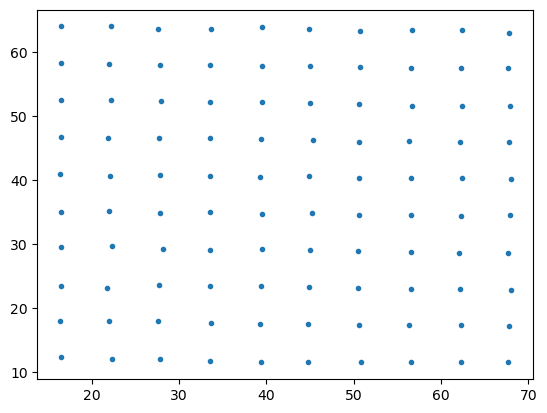

In [ ]:
im = plt.plot(*positions.T, '.')

In [ ]:
im